In [1]:
# Importazione librerie

import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

# Data preparation

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
# Mantengo solo le colonne necessarie al clustering

clust_df = df[['Lemmatized Text', 'Score']]

In [5]:
clust_df.head()

,Lemmatized Text,Score
0,"[bought, several, vitality, canned, dog, food,...",5
1,"[product, arrived, labelled, lumbo, halted, pe...",1
2,"[connection, around, century, light, pillow, c...",4
3,"[looking, secret, ingredient, robitussin, beli...",2
4,"[great, staff, great, price, wide, assortment,...",5


Campionamento dello stesso numero di osservazione da ciascuna classe

In [6]:
sample_size = clust_df.groupby('Score').count().min()[0] # Prendo come dimensione quella minima fra tutte le classi

df_downsampled = clust_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Lemmatized Text,Score
332542,"[like, others, tried, coffee, basis, consumer,...",1
238342,"[product, fails, repel, rat, period, sister, r...",1
288933,"[big, banner, front, boxwhole, grainingredient...",1
332564,"[description, right, case, rotationthe, bottle...",1
310837,"[wanted, much, like, product, heard, wonderful...",1
...,...,...
153194,"[best, pushkin, spice, coffee, ive, ever, tast...",5
29656,"[im, big, fan, drunken, donets, vanilla, chair...",5
294524,"[two, seven, month, old, yorkpoor, love, love,...",5
389106,"[found, pantry, looking, fruit, cream, quaker,...",5


Text(0, 0.5, 'Number of reviews')

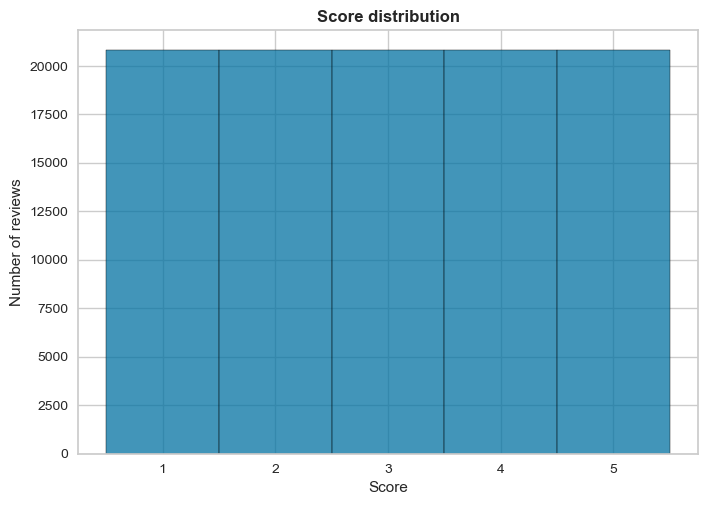

In [7]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [8]:
# Eseguo uno shuffle dei dati

df_4_clustering = shuffle(df_downsampled, random_state = 123)
df_4_clustering.reset_index(drop=True, inplace=True)
df_4_clustering.head()

,Lemmatized Text,Score
0,"[bought, product, ingredient, grain, thinking,...",1
1,"[love, think, thin, bar, love, eat, one, every...",2
2,"[far, best, whole, wheat, spaghetti, tried, fi...",5
3,"[turkey, dinner, one, two, sprout, stage, meal...",4
4,"[make, crystal, light, lemonade, home, pitcher...",2


In [9]:
# Divido x e y

x_clust = df_4_clustering['Lemmatized Text']
y_clust = df_4_clustering['Score']

In [10]:
# Dal momento che l'agglomerative clustering è molto più dispendioso riduco la dimensione dei dati usati in quel caso

df_4_agglomerative = df_4_clustering.groupby('Score', group_keys=False).apply(lambda x: x.sample(2000))
df_4_agglomerative = shuffle(df_4_agglomerative, random_state = 123)
df_4_agglomerative.reset_index(drop=True, inplace=True)
df_4_agglomerative

,Lemmatized Text,Score
0,"[decided, buy, packet, try, way, easier, get, ...",2
1,"[ive, gotten, mummy, cummins, many, time, dog,...",1
2,"[husband, type, ii, diabetes, past, list, food...",5
3,"[year, old, best, friend, tried, dog, biscuit,...",1
4,"[somehow, chocolate, really, doesnt, much, fla...",3
...,...,...
9995,"[excellent, tea, use, use, another, brand, cau...",5
9996,"[found, life, wonderful, taste, size, fall, aw...",4
9997,"[product, many, claim, making, appear, healthy...",3
9998,"[almost, never, write, review, thought, would,...",1


In [11]:
x_clust_agg = df_4_agglomerative['Lemmatized Text']
y_clust_agg = df_4_agglomerative['Score']

# Clustering

## Bag Of Words

#### Optimal number of clusters for K-Means

In [12]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(x_clust.astype(str)) 
x_clust_BOW = cv_model.transform(x_clust.astype(str))

In [13]:
tSVD_BOW = TruncatedSVD(n_components = 1413)
SVD_BOW = tSVD_BOW.fit(x_clust_BOW)
x_clust_BOW = tSVD_BOW.transform(x_clust_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.8464331425884863


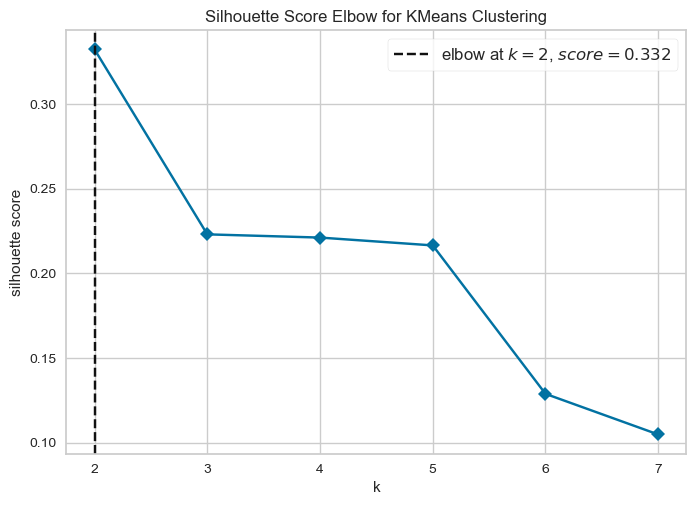

In [14]:
# Silhouette Score for K means
model = KMeans(random_state=123)
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_clust_BOW)
visualizer.show()

#### Optimal number of clusters for Agglomerative clustering

In [15]:
cv_agg = CountVectorizer(min_df=0., max_df=1.0)
cv_model_agg = cv_agg.fit(x_clust_agg.astype(str)) 
x_agg_BOW = cv_model_agg.transform(x_clust_agg.astype(str))

In [16]:
tSVD_BOW_agg = TruncatedSVD(n_components = 1413)
SVD_BOW_agg = tSVD_BOW_agg.fit(x_agg_BOW)
x_agg_BOW = tSVD_BOW_agg.transform(x_agg_BOW)
print(SVD_BOW_agg.explained_variance_ratio_.sum())

0.8999183683338289


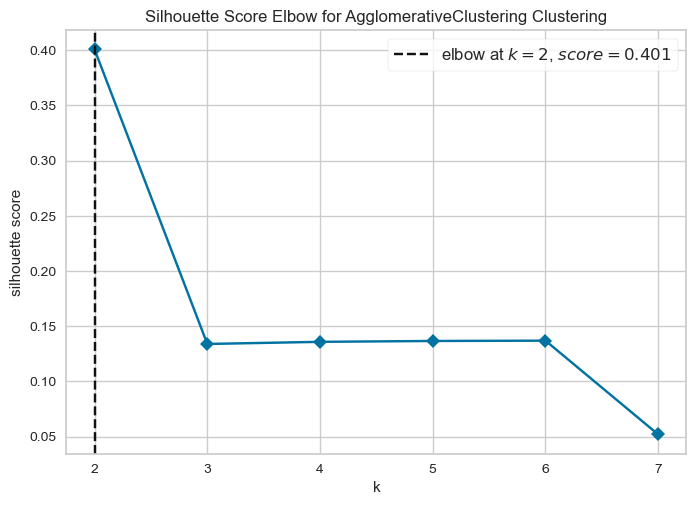

In [17]:
# Silhouette Score for Agglomerative clustering
model = AgglomerativeClustering()
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_agg_BOW)
visualizer.show()

## TF-IDF

#### Optimal number of clusters for K-Means

In [12]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(x_clust.astype(str))
x_clust_TFIDF = tv.transform(x_clust.astype(str))

In [14]:
tSVD_TFIDF = TruncatedSVD(n_components = 4719)
SVD_TFIDF = tSVD_TFIDF.fit(x_clust_TFIDF)
x_clust_TFIDF = tSVD_TFIDF.transform(x_clust_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

MemoryError: Unable to allocate 3.58 GiB for an array with shape (101509, 4729) and data type float64

In [ ]:
# Silhouette Score for K means
model = KMeans(random_state=123)
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_clust_TFIDF)
visualizer.show()

#### Optimal number of clusters for Agglomerative clustering

In [ ]:
tv_agg = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_agg = tv_agg.fit(x_clust_agg.astype(str))
x_agg_TFIDF = tv_model_agg.transform(x_clust_agg.astype(str))

In [ ]:
tSVD_TFIDF_agg = TruncatedSVD(n_components = 4719)
SVD_TFIDF_agg = tSVD_TFIDF_agg.fit(x_agg_TFIDF)
x_agg_TFIDF = tSVD_TFIDF_agg.transform(x_agg_TFIDF)
print(SVD_TFIDF_agg.explained_variance_ratio_.sum())

0.6317755809034873


In [ ]:
# Silhouette Score for Agglomerative clustering
model = AgglomerativeClustering()
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_agg_TFIDF)
visualizer.show()

## Word2Vec

#### Optimal number of clusters for K-Means

In [ ]:
w2v_model = gensim.models.Word2Vec(x_clust, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [ ]:
x_clust_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust])

In [ ]:
x_clust_avg = []
for v in x_clust_vect:
    if v.size:
        x_clust_avg.append(v.mean(axis=0))
    else:
        x_clust_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Silhouette Score for K means
model = KMeans(random_state=123)
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_clust_avg)
visualizer.show()

#### Optimal number of clusters for Agglomerative clustering

In [ ]:
w2v_model = gensim.models.Word2Vec(x_clust_agg, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [ ]:
x_clust_agg_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust_agg])

In [ ]:
x_agg_w2v = []
for v in x_clust_agg_vect:
    if v.size:
        x_agg_w2v.append(v.mean(axis=0))
    else:
        x_agg_w2v.append(np.zeros(300, dtype=float))

In [ ]:
# Silhouette Score for Agglomerative clustering
model = AgglomerativeClustering()
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)
visualizer.fit(x_agg_w2v)
visualizer.show()

# K-Means - optimal results

In [18]:
nk_bow = 2
nk_tf = 2
nk_w2v = 2

#### BOW

In [20]:
# Scelto il k ottimale, definisco il clustering

k_means_bow = KMeans(n_clusters=nk_bow, max_iter=20, n_init=10, random_state=123)
labels_bow = k_means_bow.fit_predict(x_clust_BOW)

In [21]:
# Performance modello di clustering

print(sklearn.metrics.silhouette_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels_bow))

0.3322617849347062
2652.908648943751
5.366557250614493


In [22]:
# Creo delle liste contenete gli elementi dei vari cluster, così da fare delle word cloud e analisi specifiche per cluster

bow_cluster1,bow_cluster2=[],[]
for i in range(k_means_bow.labels_.shape[0]):
    if k_means_bow.labels_[i] == 0:
        bow_cluster1.append(x_clust[i])
    else:
        bow_cluster2.append(x_clust[i])

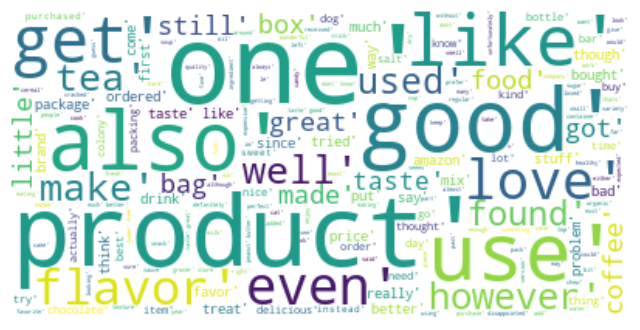

In [23]:
# Cluster 1
data=''
for i in bow_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

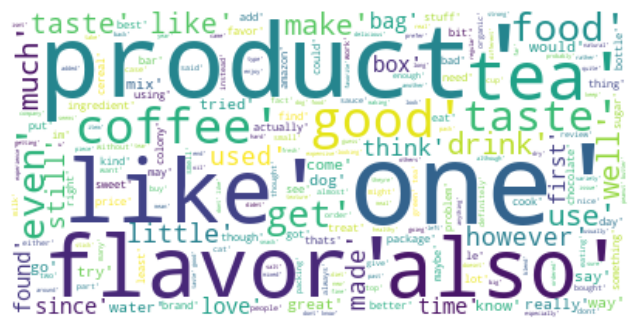

In [24]:
# Cluster 2
data=''
for i in bow_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
cluster_list = [bow_cluster1, bow_cluster2]
print("Top 5 terms per cluster:")
for i in range(2):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: taste like product good one
Cluster 2: like taste one coffee product


#### TF-IDF

In [23]:
# Scelto il k ottimale, definisco il clustering

k_means_tf = KMeans(n_clusters=nk_tf, max_iter=20, n_init=10, random_state=123)
labels_tf = k_means_tf.fit_predict(x_clust_TFIDF)

In [24]:
# Performance modello di clustering

print(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels_tf))

56291.33733465323
0.026667480469992396
1071.4744518286413
5.084042169218741


In [25]:
tf_cluster1,tf_cluster2,tf_cluster3=[],[],[]
for i in range(k_means_tf.labels_.shape[0]):
    if k_means_tf.labels_[i] == 0:
        tf_cluster1.append(x_clust[i])
    elif k_means_tf.labels_[i] == 1:
        tf_cluster2.append(x_clust[i])
    else:
        tf_cluster3.append(x_clust[i])

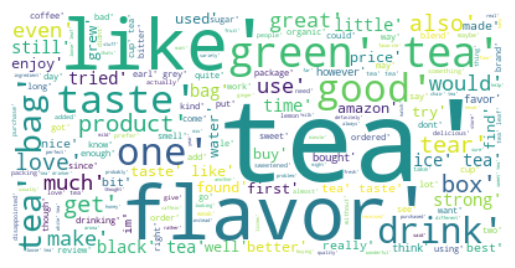

In [26]:
# Cluster 1
data=''
for i in tf_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

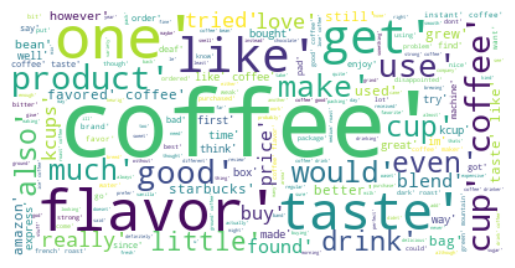

In [27]:
# Cluster 2
data=''
for i in tf_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

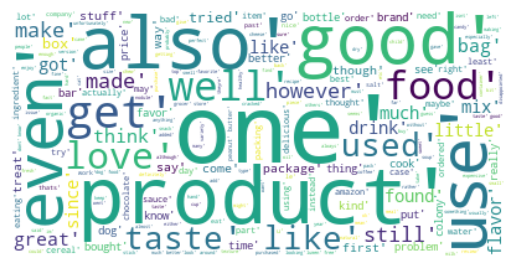

In [28]:
# Cluster 3
data=''
for i in tf_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
cluster_list = [tf_cluster1, tf_cluster2, tf_cluster3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea taste like flavor good
Cluster 2: coffee like taste cup flavor
Cluster 3: like taste product good one


#### W2V

In [33]:
# Scelto il k ottimale, definisco il clustering

k_means_w2v = KMeans(n_clusters=nk_w2v, max_iter=20, n_init=10, random_state=123)
labels_w2v = k_means_w2v.fit_predict(x_clust_avg)

In [34]:
# Performance modello di clustering

print(sklearn.metrics.silhouette_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels_w2v))

1570412.6538235196
0.08086216646778188
7794.9993222409485
2.6544993776384276


In [35]:
w2v_cluster1,w2v_cluster2,w2v_cluster3,w2v_cluster4=[],[],[],[]
for i in range(k_means_w2v.labels_.shape[0]):
    if k_means_w2v.labels_[i] == 0:
        w2v_cluster1.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 1:
        w2v_cluster2.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 2:
        w2v_cluster3.append(x_clust[i])
    else:
        w2v_cluster4.append(x_clust[i])

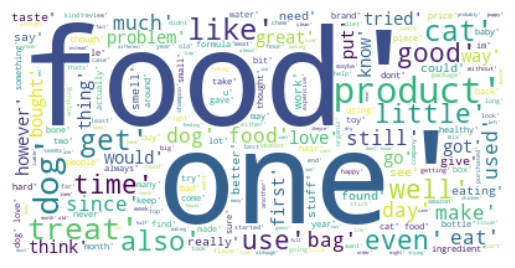

In [36]:
# Cluster 1
data=''
for i in w2v_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

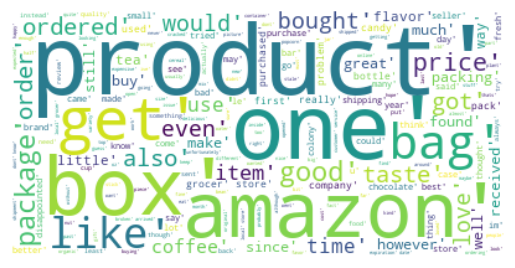

In [37]:
# Cluster 2
data=''
for i in w2v_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
cluster_list = [w2v_cluster1, w2v_cluster2, w2v_cluster3, w2v_cluster4]
print("Top 5 terms per cluster:")
for i in range(4):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: dog food like product cat
Cluster 2: product amazon box one price
Cluster 3: coffee tea taste like flavor
Cluster 4: taste like good flavor product


# Agglomerative - optimal results

In [19]:
nagg_bow = 2
nagg_tf = 2
nagg_w2v = 2

### BOW

In [26]:
# Scelto il k ottimale, definisco il clustering
agg_bow = AgglomerativeClustering(n_clusters=nagg_bow)
labels_bow_agg = agg_bow.fit_predict(x_agg_BOW)

print(sklearn.metrics.silhouette_score(x_agg_BOW, labels_bow_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_BOW, labels_bow_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_BOW, labels_bow_agg))

0.4006923707492664
149.38923960304538
5.642235285180976


In [27]:
agg_bow_1,agg_bow_2=[],[]
for i in range(agg_bow.labels_.shape[0]):
    if agg_bow.labels_[i] == 0:
        agg_bow_1.append(x_clust_agg[i])
    else:
        agg_bow_2.append(x_clust_agg[i])

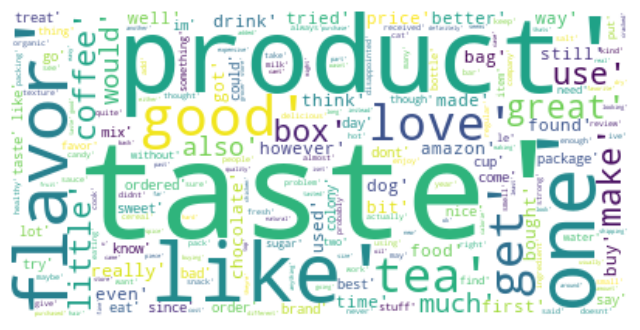

In [28]:
# Cluster 1
data=''
for i in agg_bow_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

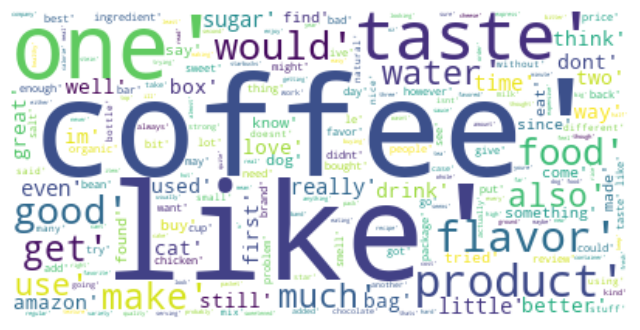

In [29]:
# Cluster 2
data=''
for i in agg_bow_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
cluster_list = [agg_bow_1, agg_bow_2]
print("Top 5 terms per cluster:")
for i in range(2):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: like taste product good one
Cluster 2: like coffee taste one food


### TF-IDF

In [37]:
# Scelto il k ottimale, definisco il clustering
agg_TFIDF = AgglomerativeClustering(n_clusters=nagg_tf)
labels_TFIDF_agg = agg_TFIDF.fit_predict(x_agg_TFIDF)

print(sklearn.metrics.silhouette_score(x_agg_TFIDF, labels_TFIDF_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_TFIDF, labels_TFIDF_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_TFIDF, labels_TFIDF_agg))

0.011221915107252576
68.47463034165861
6.114731147078943


In [38]:
agg_TFIDF_1,agg_TFIDF_2,agg_TFIDF_3=[],[],[]
for i in range(agg_TFIDF.labels_.shape[0]):
    if agg_TFIDF.labels_[i] == 0:
        agg_TFIDF_1.append(x_clust_agg[i])
    elif agg_TFIDF.labels_[i] == 1:
        agg_TFIDF_2.append(x_clust[i])
    else:
        agg_TFIDF_3.append(x_clust_agg[i])

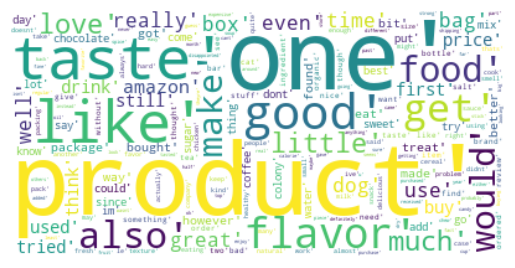

In [39]:
# Cluster 1
data=''
for i in agg_TFIDF_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

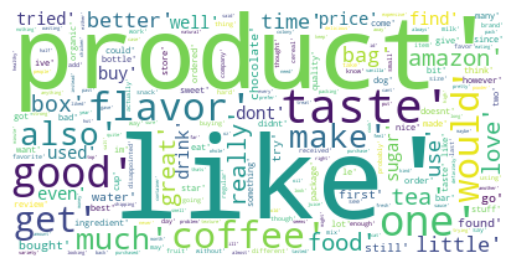

In [40]:
# Cluster 2
data=''
for i in agg_TFIDF_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

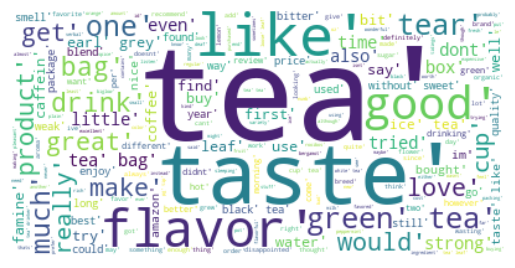

In [41]:
# Cluster 3
data=''
for i in agg_TFIDF_3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
cluster_list = [agg_TFIDF_1, agg_TFIDF_2,agg_TFIDF_3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: like taste product good one
Cluster 2: like taste product good one
Cluster 3: tea like taste flavor green


## W2V

In [48]:
# Scelto il k ottimale, definisco il clustering
agg_w2v = AgglomerativeClustering(n_clusters=nagg_w2v)
labels_w2v_agg = agg_w2v.fit_predict(x_agg_w2v)

print(sklearn.metrics.silhouette_score(x_agg_w2v, labels_w2v_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_w2v, labels_w2v_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_w2v, labels_w2v_agg))

0.17771693
2265.203461042847
1.5818538659957484


In [49]:
agg_w2v_1,agg_w2v_2,agg_w2v_3=[],[],[]
for i in range(agg_w2v.labels_.shape[0]):
    if agg_w2v.labels_[i] == 0:
        agg_w2v_1.append(x_clust_agg[i])
    elif agg_w2v.labels_[i] == 1:
        agg_w2v_2.append(x_clust[i])
    else:
        agg_w2v_3.append(x_clust_agg[i])

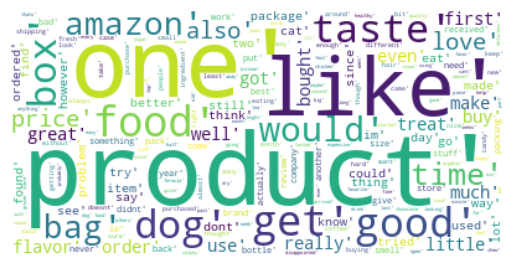

In [50]:
# Cluster 1
data=''
for i in agg_w2v_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

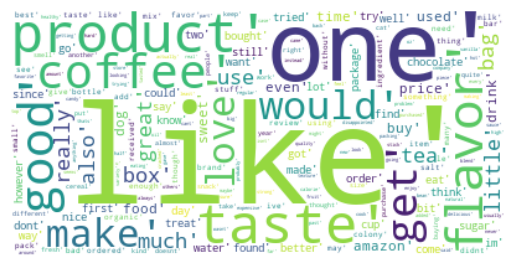

In [51]:
# Cluster 2
data=''
for i in agg_w2v_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

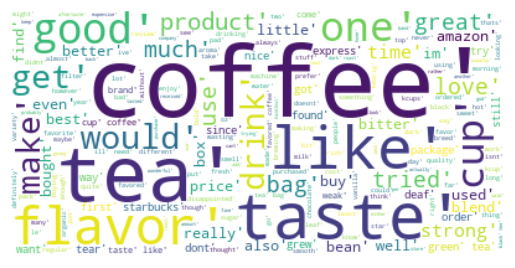

In [52]:
# Cluster 3
data=''
for i in agg_w2v_3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
cluster_list = [agg_w2v_1,agg_w2v_2,agg_w2v_3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: product like one food dog
Cluster 2: like taste product one good
Cluster 3: coffee tea taste like cup


# Link utili

Misure di performance: https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/